In [1]:
import pandas as pd
from constants import *
from os.path import join
import json
from topic_coherence_experiments import *
%pylab inline
#pylab.rcParams['figure.figsize'] = (20, 20)
import seaborn as sns
from itertools import islice

Populating the interactive namespace from numpy and matplotlib


/home/andreas/bin/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


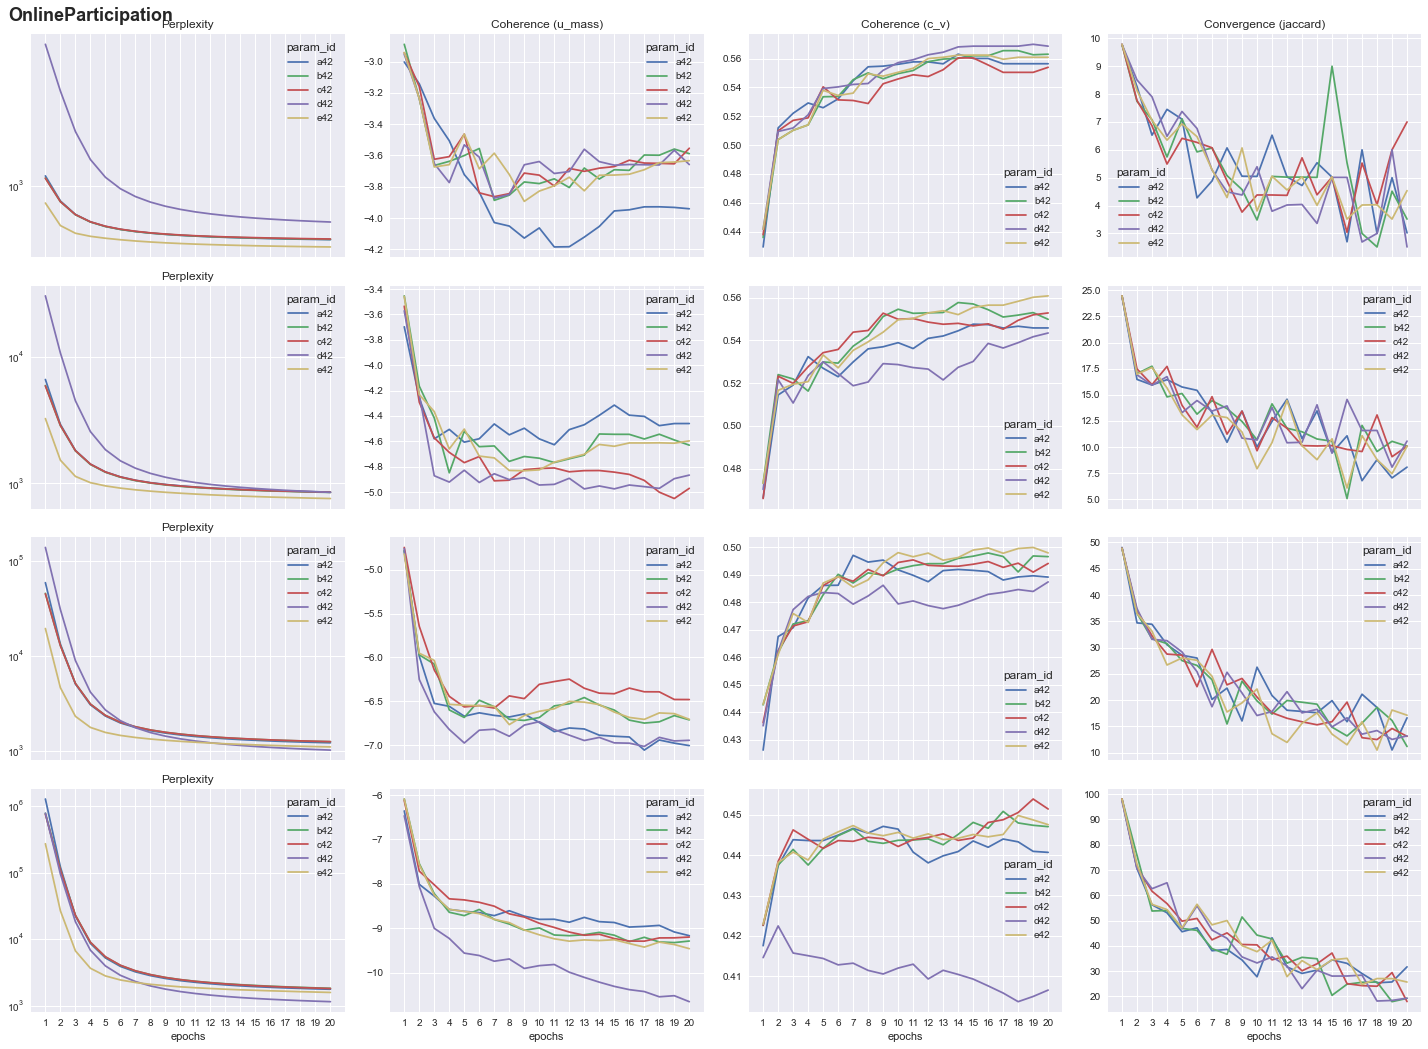

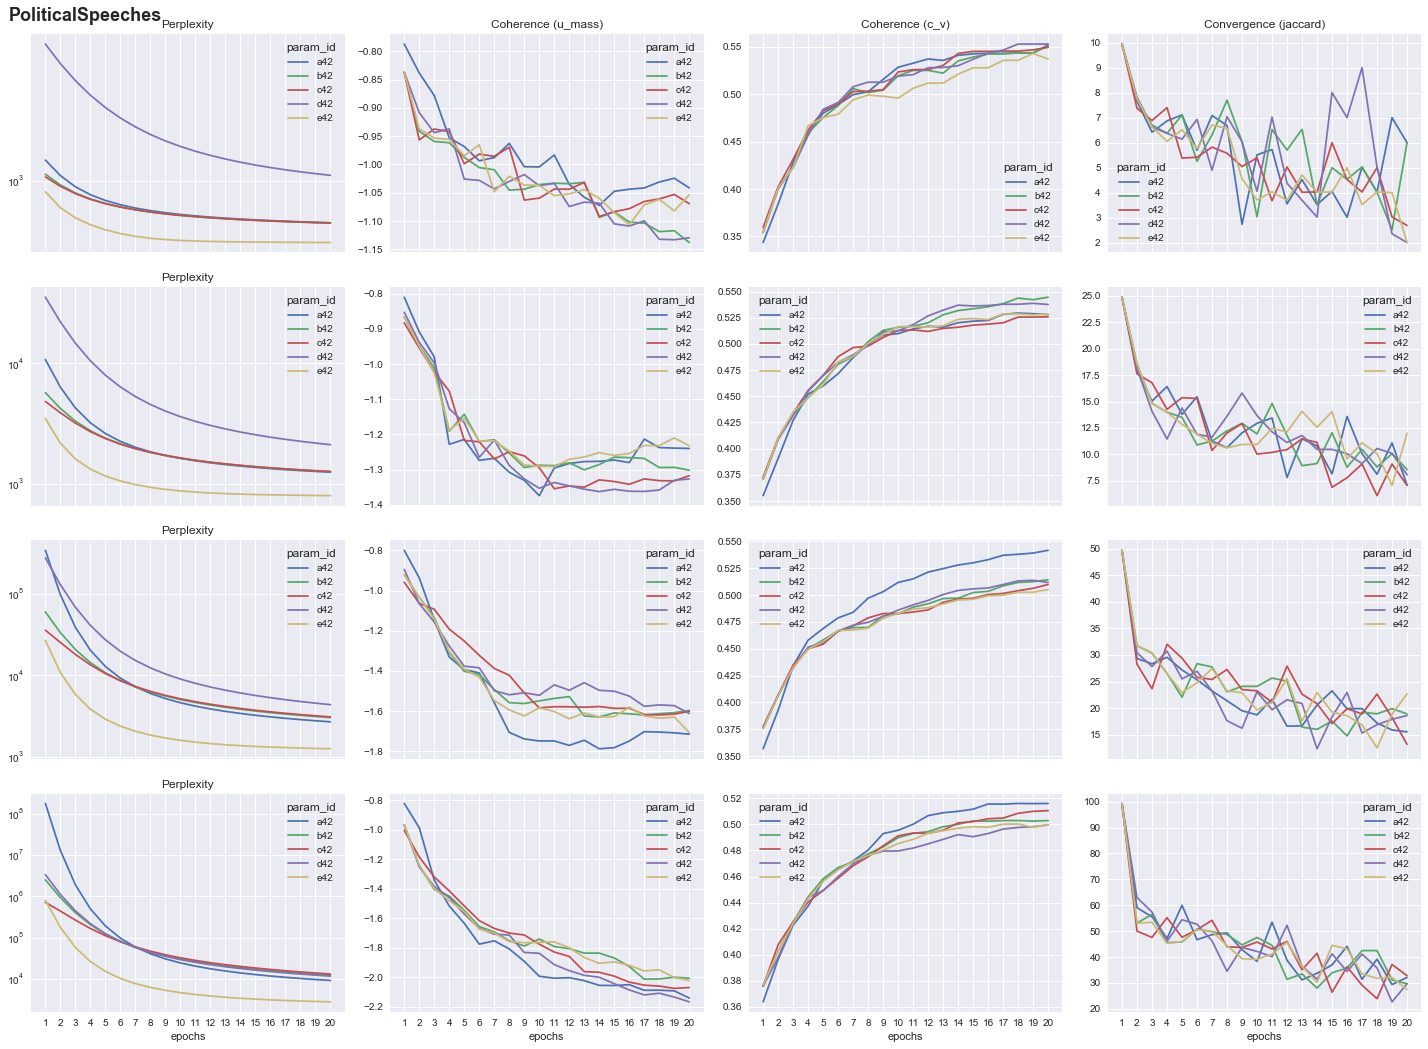

In [7]:
pert = 'Perplexity (test)'
cohu = 'Coherence (u_mass)'
cohc = 'Coherence (c_v)'
conv = 'Convergence (jaccard)'
metrics = [perh, cohu, cohc, conv]


def load_metrics(dataset):
    param_ids = [f'{c}42' for c in list('abcde')]
    nb_topics_list = [10, 25, 50, 100]
    metrics = []
    for param_id in param_ids:
        for nb_topics in nb_topics_list:
            file = join(ETL_PATH, 'LDAmodel', param_id, f'{dataset}_LDAmodel_{param_id}_{nb_topics}_metrics.json')
            with open(file, 'r') as fp:
                data = json.load(fp)
            df = pd.DataFrame.from_dict(data)
            df = df.assign(
                dataset=dataset,
                param_id=param_id,
                nb_topics=nb_topics,
            )
            df.index += 1
            df.index.name = 'epochs'
            df = df.set_index(['dataset', 'param_id', 'nb_topics'], append=True).reorder_levels([1, 2, 3, 0])
            df.columns = ['Perplexity (test)', 'Coherence (u_mass)', 'Coherence (c_v)',
                                   'Diff (kullback_leibler)', 'Convergence (jaccard)']
            metrics.append(df)
    return pd.concat(metrics)

def subframes(df, n):
    d = df.query(f'nb_topics == {n}')
    d.index = d.index.droplevel(['dataset', 'nb_topics'])
    d_pert = d[pert].unstack('epochs').T
    d_cohu = d[cohu].unstack('epochs').T
    d_cohc = d[cohc].unstack('epochs').T
    d_conv = d[conv].unstack('epochs').T
    return d_pert, d_cohu, d_cohc, d_conv

def run(dataset):
    df = load_metrics(dataset)
    subf = [subframes(df, 10), subframes(df, 25), subframes(df, 50), subframes(df, 100)]
    return df, subf

def plot(dataset, data):
    sns.set()
    pylab.rcParams['figure.figsize'] = (20, 15)
    xticks=range(1, 21)

    fig, axs = plt.subplots(nrows=len(data), ncols=len(metrics))
    for i, subframes in enumerate(data):
        for j, kv in enumerate(zip(metrics, subframes)):
            metric, subframe = kv
            kwargs = dict()
            if i == 0:
                kwargs['title'] = metric
            if metric.startswith('Per'):
                kwargs['title'] = 'Perplexity'
                kwargs['logy'] = True
            subframe.plot(ax=axs[i][j], xticks=xticks, sharex=True, **kwargs)
    fig.suptitle(DATASETS[dataset], size=18, weight='heavy', x=.01, y=.97, ha='left', va='top')
    plt.tight_layout(rect=[0, 0, 1, 0.97])

#dfdewa, dewa = run(DATASETS['dewa'])
#dfe, e = run(DATASETS['E'])
#dffa, fa = run(DATASETS['FA'])
#dffo, fo = run(DATASETS['FO'])
dfo, o = run(DATASETS['O'])
dfp, p = run(DATASETS['P'])

alldata = {
    #'dewa': dewa,
    #'E': e,
    #'FA': fa,
    #'FO': fo,
    'O': o,
    'P': p
}

for k, v in islice(alldata.items(), None):
    plot(k, v)